In [130]:
import os
import re

import joblib
import torch
import numpy as np
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_core.documents import Document
from langchain_cerebras import ChatCerebras
from langchain_openai import ChatOpenAI
from pymilvus import connections, Collection
from pymilvus.model.hybrid import BGEM3EmbeddingFunction
from fastembed import LateInteractionTextEmbedding
from langgraph.graph import START, StateGraph
from pydantic import BaseModel, Field
from typing_extensions import List, Dict, TypedDict

In [131]:
load_dotenv()

True

## Connect to Vector Database

In [132]:
# Utilize GPU to load and infer the embedding model if available 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# This is the parameter to connect to the Zilliz vector database
ZILLIZ_URI = os.getenv("ZILLIZ_URI")
ZILLIZ_USER = os.getenv("ZILLIZ_USER")
ZILLIZ_PASSWORD = os.getenv("ZILLIZ_PASSWORD")
COLLECTION_NAME = "emgt_605_bge_bm25_500_50"

# The file path to load the sparse embeddings
SPARSE_EMBEDDINGS_PATH = "../artifact/emgt605/sparse_embeddings.joblib"

# The name of ColBERT model that will be used as a reranker
COLBERT_MODEL_NAME = "answerdotai/answerai-colbert-small-v1"

# Enable the tracing feature of Langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [133]:
class ColBERTReranker(LateInteractionTextEmbedding):
    def __init__(self, model_name: str = "answerdotai/answerai-colbert-small-v1", **kwargs) -> None:
        """
        Initializes the ColBERTReranker with the given model name.
        """
        super().__init__(model_name=model_name, **kwargs)

    def compute_relevance_scores(self, query_embedding: np.array, document_embeddings: np.array, k: int) -> List[int]:
        """
        Compute relevance scores for top-k documents given a query.
        """
        # Compute batch dot-product of query_embedding and document_embeddings
        # Resulting shape: [num_documents, num_query_terms, max_doc_length]
        scores = np.matmul(query_embedding, document_embeddings.transpose(0, 2, 1))

        # Apply max-pooling across document terms (axis=2) to find the max similarity per query term
        # Shape after max-pool: [num_documents, num_query_terms]
        max_scores_per_query_term = np.max(scores, axis=2)

        # Sum the scores across query terms to get the total score for each document
        # Shape after sum: [num_documents]
        total_scores = np.sum(max_scores_per_query_term, axis=1)

        # Sort the documents based on their total scores and get the indices of the top-k documents
        sorted_indices = np.argsort(total_scores)[::-1][:k]

        return list(sorted_indices)

    def rerank_docs_query(self, docs: List[str], query: str, top_k: int = 5, return_indices: bool = False) -> List[str] or List[int]:
        """
        Rerank the documents based on the query. Can return the indices of the top-k documents or the documents themselves.
        """
        document_embeddings = list(self.embed(docs))
        query_embeddings = list(self.embed([query]))
        
        sorted_indices = self.compute_relevance_scores(
        np.array(query_embeddings[0]), np.array(document_embeddings), k=top_k
        )
        
        if return_indices:
            return sorted_indices
        else:
            return [docs[i] for i in sorted_indices]

In [134]:
class ZillizVectorSearch:
    def __init__(
        self,
        zilliz_user: str,
        zilliz_password: str,
        zilliz_uri: str,
        collection_name: str,
        sparse_embeddings,
        dense_embeddings,
        colbert_reranker,
    ) -> None:
        """
        Initializes the VectorSearch class with necessary details.
        """
        self.zilliz_user = zilliz_user
        self.zilliz_password = zilliz_password
        self.zilliz_uri = zilliz_uri
        self.collection_name = collection_name
        self.sparse_embeddings = sparse_embeddings
        self.dense_embeddings = dense_embeddings
        self.reranker = colbert_reranker

        # Connect to the collection
        self.collection = self.retrieve_collection()

    def retrieve_collection(self) -> Collection:
        """
        Retrieve the collection from Zilliz.
        """
        connections.connect(
            uri=self.zilliz_uri, user=self.zilliz_user, password=self.zilliz_password
        )
        return Collection(self.collection_name)

    def search(self, query: str, embedding_type: str, top_k: int) -> List[Dict]:
        """
        Perform the search on a specific vector type (dense or sparse).
        """
        if embedding_type == "dense":
            anns_field = "dense_vector"
            metric_type = "COSINE"
            query = self.dense_embeddings.encode_queries([query])["dense"]
        elif embedding_type == "sparse":
            anns_field = "sparse_vector"
            metric_type = "IP"
            query = self.sparse_embeddings.encode_queries([query])
        else:
            raise ValueError("Invalid embedding type. Must be either 'dense' or 'sparse'.")

        output_fields = [
            "pk",
            "start_index",
            "data_block_ranges",
            "module_title",
            "subsection",
            "submodule_title",
            "submodule_url",
            "text",
        ]

        results = self.collection.search(
            query,
            anns_field=anns_field,
            limit=top_k,
            param={"metric_type": metric_type},
            output_fields=output_fields,
        )
        results = [result.to_dict()["entity"] for result in results[0]]

        return results

    def hybrid_search(self, query: str, top_k_each: int = 5, top_k_final: int = 5) -> List[Dict]:
        """
        Perform a hybrid search combining dense and sparse searches.
        """
        pk_set = set()
        unique_results = []

        # Search for both dense and sparse results
        dense_results = self.search(query, "dense", top_k_each)
        sparse_results = self.search(query, "sparse", top_k_each)
        all_results = dense_results + sparse_results

        # Combine dense and sparse results and remove duplicates
        for result in all_results:
            if result["pk"] not in pk_set:
                pk_set.add(result["pk"])
                unique_results.append(result)

        # Rerank the results
        sorted_indices = self.reranker.rerank_docs_query(
            [result["text"] for result in unique_results], query, top_k=top_k_final, return_indices=True
        )
        ranked_results = [unique_results[i] for i in sorted_indices]
        return ranked_results

In [135]:
dense_embeddings = BGEM3EmbeddingFunction(use_fp16=False, device=DEVICE, return_dense=True, return_sparse=False)
sparse_embeddings = joblib.load(SPARSE_EMBEDDINGS_PATH)
colbert_reranker = ColBERTReranker(model_name=COLBERT_MODEL_NAME)
vector_search = ZillizVectorSearch(ZILLIZ_USER, ZILLIZ_PASSWORD, ZILLIZ_URI, COLLECTION_NAME, sparse_embeddings, dense_embeddings, colbert_reranker)

Fetching 30 files: 100%|██████████| 30/30 [00:00<?, ?it/s]


## Initialize LLM

In [21]:
# GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# llm = ChatGroq(api_key=GROQ_API_KEY, model="llama-3.3-70b-versatile", temperature=0, max_retries=3)

# CEREBRAS_API_KEY = os.getenv("CEREBRAS_API_KEY")
# llm = ChatCerebras(api_key=CEREBRAS_API_KEY, model="llama-3.3-70b", temperature=0, max_retries=3)

from langchain_openai import ChatOpenAI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o", temperature=0, max_retries=3)

## Prompt and Flow Testing

We will test several patterns for the RAG system. Sources are defined as the context retrieved from the vector database while quotes are a specific span of the source that is used to formulate the final answer.

#### Pattern 1: Answer with list of quotes

In [44]:
def _load_generate_prompt(course_name):
    generate_system_prompt = f"""You're a helpful personalized tutor for {course_name}. Given a user question and some course contents, answer the question thoroughly based on the course contents and justify all part of your answer by providing verbatim citations and SOURCE ID. If none of the course content answer the question, just say: "Sorry, I can't find any relevant course content related to your question". 

    Here are the course contents (not visible to the user):
    {{sources}}"""

    return ChatPromptTemplate.from_messages([
        ("system", generate_system_prompt),
        ("human", "{question}"),
    ])

generate_prompt = _load_generate_prompt("Sustainability Systems in Engineering")

In [51]:
def add_contextual_headers(doc):
    context = f"Content snippet of: {doc['module_title']} - {doc['subsection']}: {doc['submodule_title']}"
    return context + "\n" + doc['text']

def format_sources_with_id(sources: List[Dict]) -> str:
    for source in sources:
        contextual_text = add_contextual_headers(source)
        source['text'] = contextual_text
    
    formatted = [
        f"SOURCE ID: {i}\nContent: {source['text']}"
        for i, source in enumerate(sources)
    ]
    return "\n\n" + "\n---\n".join(formatted)

class Citation(BaseModel):
    source_id: int = Field(
        ...,
        description="The integer ID of a SPECIFIC source which justifies the answer.",
    )
    quote: str = Field(
        ...,
        description="The DIRECT quote from the specified source that justifies the answer.",
    )

class QuotedAnswer(BaseModel):
    """Answer the user question thoroughly based only on the given sources, and cite all the sources used."""

    answer: str = Field(
        ...,
        description="The final answer to the user question based on the given sources. Do not include the term 'SOURCE ID'.",
    )
    citations: List[Citation] = Field(
        ..., description="Citations from the given sources that justify the answer."
    )
    
class State(TypedDict):
    question: str
    sources: List[Dict]
    answer: QuotedAnswer

def retrieve(state: State):
    retrieved_sources = vector_search.hybrid_search(query=state["question"], top_k_final=3)
    return {"sources": retrieved_sources}

def generate_answer(state: State):
    formatted_sources = format_sources_with_id(state["sources"])
    messages = generate_prompt.invoke({"question": state["question"], "sources": formatted_sources})
    structured_llm = llm.with_structured_output(QuotedAnswer)
    response = structured_llm.invoke(messages)
    return {"answer": response}

def build_graph():
    graph_builder = StateGraph(State).add_sequence([retrieve, generate_answer])
    graph_builder.add_edge(START, "retrieve")
    return graph_builder.compile()

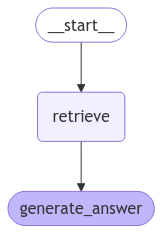

In [52]:
graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
result = graph.invoke({"question": "What are different ways to calculate GDP? Please explain them as well."})

In [54]:
print(result['answer'].answer)
print("\nCitations:\n")
print(result['answer'].citations)

GDP can be calculated using three different approaches: production-based, expenditure-based, and income-based methods.

1. **Production-based method**: This method calculates GDP by measuring the gross value added from production. It involves taking the total value of goods and services produced and subtracting the cost of inputs used in production to avoid double-counting. This approach focuses on the output of the economy.

2. **Expenditure-based method**: This method calculates GDP by looking at what is spent on the acquisition of final products and services within a specific time. It considers the total expenditure on goods and services in the economy, including consumption, investment, government spending, and net exports (exports minus imports).

3. **Income-based method**: This method calculates GDP by adding up all the income earned by households in a year, including wages, rent, and interest. It focuses on the income generated from the production of goods and services.

In a c

In [55]:
result = graph.invoke({"question": "What is the difference between economic and social impact?"})

In [56]:
print(result['answer'].answer)
print("\nCitations:\n")
print(result['answer'].citations)

The difference between economic and social impact lies in the aspects of development projects they evaluate. Economic Impact Assessment (EIA) focuses on changes in employment, income, and economic opportunities. It provides insights into how a project affects the economic landscape, often overlapping with social impact assessments to give a comprehensive view of socio-economic effects. On the other hand, Social Impact Assessment (SIA) focuses on understanding and managing the social consequences of projects. It aims to enhance positive impacts while mitigating negatives, involving community engagement, stakeholder analysis, and ongoing monitoring. SIA addresses ethical and social considerations such as human rights, labour practices, data rights, consumer issues, fairness, and community involvement.

Citations:

[Citation(source_id=0, quote='Economic Impact Assessment (EIA) evaluates changes in employment, income, and economic opportunities. It often overlaps with SIA to provide a comp

In [57]:
result = graph.invoke({"question": "How to increase the speed of a car?"})

In [58]:
print(result['answer'].answer)
print("\nCitations:\n")
print(result['answer'].citations)

Sorry, I can't find any relevant course content related to your question.

Citations:

[]


Problem: Incosistency between the source and the quote, quote sometimes are not an exact match of the source, so hard to backtrace to the original source.

#### Pattern 2: 1) Answer with list of quotes, 2) Add inline citation

In [87]:
def _load_generate_prompt(course_name):
    generate_system_prompt = f"""You're a helpful personalized tutor for {course_name}. Given a user question and some course contents, answer the question thoroughly based on the course contents and justify all part of your answer by providing verbatim citations and SOURCE ID. If none of the course content answer the question, just say: "Sorry, I can't find any relevant course content related to your question". 

    Here are the course contents (not visible to the user):
    {{sources}}"""

    return ChatPromptTemplate.from_messages([
        ("system", generate_system_prompt),
        ("human", "{question}"),
    ])

generate_prompt = _load_generate_prompt("Sustainability Systems in Engineering")

In [88]:
def _load_inline_citation_prompt():
    inline_citation_system_prompt = """You're a professional citation formatter. You will be given a question and answer along with the relevant quotes that justify the answer. Your task is to generate an inline citation for the final answer by matching relevant portions of the answer with the corresponding quote IDs. Do not include the term "QUOTE ID" in the final answer.
Follow the following format for the final answer:
This is an example of inline citation^[1]. One sentence can have multiple inline citations^[2], if they are supported by multiple quotes^[3].

Here are the relevant quotes:
{quotes}
"""

    inline_citation_human_prompt = """
Question: {question}

Answer: {answer}
    
Formatted answer:
"""

    return ChatPromptTemplate.from_messages([
        ("system", inline_citation_system_prompt),
        ("human", inline_citation_human_prompt),
    ])
    
inline_citation_prompt = _load_inline_citation_prompt()

In [89]:
def add_contextual_headers(doc):
    context = f"Content snippet of: {doc['module_title']} - {doc['subsection']}: {doc['submodule_title']}"
    return context + "\n" + doc['text']

def format_sources_with_id(sources: List[Dict]) -> str:
    for source in sources:
        contextual_text = add_contextual_headers(source)
        source['text'] = contextual_text
    
    formatted = [
        f"SOURCE ID: {i}\nContent: {source['text']}"
        for i, source in enumerate(sources)
    ]
    return "\n\n" + "\n---\n".join(formatted)

def format_quotes_with_id(citations):
    formatted = [
        f"QUOTE ID: {i}\nContent: {citation.quote}"
        for i, citation in enumerate(citations)
    ]
    return "\n\n" + "\n---\n".join(formatted)
    
class Citation(BaseModel):
    source_id: int = Field(
        ...,
        description="The integer ID of a SPECIFIC source which justifies the answer.",
    )
    quote: str = Field(
        ...,
        description="The VERBATIM quote from the specified source that justifies the answer.",
    )


class QuotedAnswer(BaseModel):
    """Answer the user question thorougly based only on the given sources, and cite all the sources used."""

    answer: str = Field(
        ...,
        description="The final answer to the user question based on the given sources. Do not include the term 'SOURCE ID'.",
    )
    citations: List[Citation] = Field(
        ..., description="Citations from the given sources that justify the answer."
    )
    
class State(TypedDict):
    question: str
    sources: List[Dict]
    intermediate_answer: QuotedAnswer
    final_answer: str

def retrieve(state: State):
    retrieved_sources = vector_search.hybrid_search(query=state["question"], top_k_final=3)
    return {"sources": retrieved_sources}

def generate_intermediate_answer(state):
    formatted_sources = format_sources_with_id(state["sources"])
    messages = generate_prompt.invoke({"question": state["question"], "sources": formatted_sources})
    structured_llm = llm.with_structured_output(QuotedAnswer)
    response = structured_llm.invoke(messages)
    return {"intermediate_answer": response}

def generate_final_answer(state):
    formatted_quotes = format_quotes_with_id(state["intermediate_answer"].citations)
    messages = inline_citation_prompt.invoke({
        "question": state["question"], 
        "answer": state['intermediate_answer'].answer, 
        "quotes": formatted_quotes
    })
    
    response = llm.invoke(messages)
    return {"final_answer": response}

def build_graph():
    graph_builder = StateGraph(State).add_sequence([
        retrieve, 
        generate_intermediate_answer, 
        generate_final_answer
    ])
    graph_builder.add_edge(START, "retrieve")
    graph_builder.add_edge("generate_intermediate_answer", "generate_final_answer")
    return graph_builder.compile()

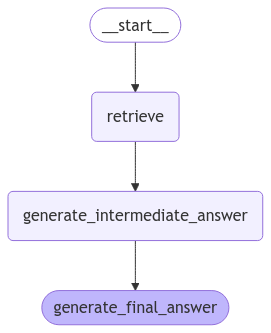

In [90]:
graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

In [91]:
result = graph.invoke({"question": "What are different ways to calculate GDP? Please explain them as well."})

In [92]:
print(result['final_answer'].content)
print("\nCitations:\n")
print(result['intermediate_answer'].citations)

GDP can be calculated using three different approaches: the production-based method, the expenditure-based method, and the income-based method^[0].

1. **Production-based method**: This method calculates GDP by measuring the gross value added from production. It involves taking the total value of goods and services produced and subtracting the cost of inputs used in production to avoid double-counting. This approach focuses on the output of the economy^[1].

2. **Expenditure-based method**: This method calculates GDP by looking at what is spent on the acquisition of final products and services within a specific time. It considers the total expenditure on goods and services in the economy, including consumption, investment, government spending, and net exports (exports minus imports)^[2].

3. **Income-based method**: This method calculates GDP by adding up all the income earned by households in a year, including wages, rent, and interest. It focuses on the income generated from the prod

In [93]:
result = graph.invoke({"question": "What is the difference between economic and social impact?"})

In [94]:
print(result['final_answer'].content)
print("\nCitations:\n")
print(result['intermediate_answer'].citations)

The difference between economic and social impact lies in the aspects of development projects they evaluate. Economic Impact Assessment (EIA) focuses on changes in employment, income, and economic opportunities^[0]. It provides insights into how a project affects the economic environment, often overlapping with social impact assessments to give a comprehensive view of socio-economic effects^[0]. On the other hand, Social Impact Assessment (SIA) focuses on understanding and managing the social consequences of projects^[1]. It aims to enhance positive impacts while mitigating negatives, involving community engagement, stakeholder analysis, and ongoing monitoring^[1]. SIA addresses ethical and social considerations such as human rights, labour practices, data rights, consumer issues, fairness, and community involvement^[2].

Citations:

[Citation(source_id=0, quote='Economic Impact Assessment (EIA) evaluates changes in employment, income, and economic opportunities. It often overlaps with

Same problem as pattern 1 as the first step of pattern 2 is the same as pattern 1.

#### Pattern 3: 1) Answer 2) Justify with inline citations and quotes

In [95]:
def _load_generate_prompt(course_name):
    generate_system_prompt = f"""You're a helpful personalized tutor for {course_name}. Given a user question and some course contents, answer the question thoroughly based on the course contents and justify all part of your answer by providing verbatim citations and SOURCE ID. If none of the course content answer the question, just say: "Sorry, I can't find any relevant course content related to your question". 

    Here are the course contents (not visible to the user):
    {{sources}}"""

    return ChatPromptTemplate.from_messages([
        ("system", generate_system_prompt),
        ("human", "{question}"),
    ])

generate_prompt = _load_generate_prompt("Sustainability Systems in Engineering")

In [96]:
def add_contextual_headers(doc):
    context = f"Content snippet of: {doc['module_title']} - {doc['subsection']}: {doc['submodule_title']}"
    return context + "\n" + doc['text']

def format_sources_with_id(sources: List[Dict]) -> str:
    for source in sources:
        contextual_text = add_contextual_headers(source)
        source['text'] = contextual_text
    
    formatted = [
        f"SOURCE ID: {i}\nContent: {source['text']}"
        for i, source in enumerate(sources)
    ]
    return "\n\n" + "\n---\n".join(formatted)

class Citation(BaseModel):
    source_id: int = Field(
        ...,
        description="The integer ID of a SPECIFIC source which justifies the answer.",
    )
    quote: str = Field(
        ...,
        description="The VERBATIM quote from the specified source that justifies the answer.",
    )

class QuotedAnswer(BaseModel):
    """Answer the user question thorougly based only on the given sources, and cite all the sources used."""

    answer: str = Field(
        ...,
        description="The final answer to the user question with inline citations. Do not include the term 'SOURCE ID'.",
    )
    citations: List[Citation] = Field(
        ..., description="Citations from the given sources that justify the answer."
    )
    
class State(TypedDict):
    question: str
    sources: List[Dict]
    answer: str
    final_answer: QuotedAnswer

def retrieve(state: State):
    retrieved_sources = vector_search.hybrid_search(query=state["question"], top_k_final=3)
    return {"sources": retrieved_sources}

def generate_answer(state: State):
    formatted_sources = format_sources_with_id(state["sources"])
    messages = generate_prompt.invoke({"question": state["question"], "sources": formatted_sources})
    response = llm.invoke(messages)
    return {"answer": response.content}

def annotate(state: State):
    formatted_docs = format_sources_with_id(state["sources"])
    messages = [
        generate_prompt.format(sources=formatted_docs, question=state["question"]),
        ("ai", state["answer"]),
        ("human", "Annotate your answer with inline citations of source IDs. E.g. This is an example of inline citation[1]. One sentence can have multiple inline citations[2], if they are supported by multiple quotes[3]."),
    ]
    structured_llm = llm.with_structured_output(QuotedAnswer)
    response = structured_llm.invoke(messages)
    return {"final_answer": response}

def build_graph():
    graph_builder = StateGraph(State).add_sequence([retrieve, generate_answer, annotate])
    graph_builder.add_edge(START, "retrieve")
    return graph_builder.compile()

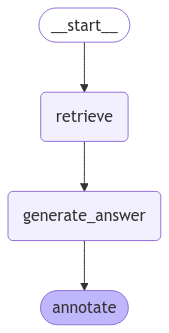

In [97]:
graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

In [98]:
result = graph.invoke({"question": "What are different ways to calculate GDP? Please explain them as well."})

In [99]:
print(result['final_answer'].answer)
print("\nCitations:\n")
print(result['final_answer'].citations)

Gross Domestic Product (GDP) can be calculated using different approaches, including the production-based, expenditure-based, and income-based methods[0].

1. **Production-based method**: This method calculates GDP by measuring the gross value added from production. It involves taking the total value of goods and services produced and subtracting the cost of inputs used in production to avoid double-counting. This approach focuses on the output of the economy[0].

2. **Expenditure-based method**: This method calculates GDP by looking at what is spent on the acquisition of final products and services within a specific time. It considers the total expenditure on goods and services in the economy, including consumption, investment, government spending, and net exports (exports minus imports)[0].

3. **Income-based method**: This method calculates GDP by adding up all the income earned by households in a year. This includes wages, rent, and interest. It focuses on the income generated from

Same problem as pattern 1.

#### Pattern 4: 1) Recursively split the sources 2) Answer with inline citation of the splitted sources

In [373]:
def _load_generate_prompt(course_name):
    generate_system_prompt = f"""You're a helpful personalized tutor for {course_name}. Given a user question and some course contents, answer the question based on the course contents and justify your answer by providing an accurate inline citation of the source IDs. If none of the course content answer the question, just say: "Sorry, I can't find any relevant course content related to your question". 
Follow the following format STRICTLY for the final answer:
This is an example of inline citation^[5]. One sentence can have multiple inline citations^[3], and the inline citation can also consist of multiple numbers^[7]^[8]. 

Here are the course contents (not visible to the user):
{{sources}}"""

    return ChatPromptTemplate.from_messages([
        ("system", generate_system_prompt),
        ("human", "{question}"),
    ])
generate_prompt = _load_generate_prompt("Sustainability Systems in Engineering")

In [370]:
# def _load_generate_prompt(course_name):
#     generate_system_prompt = f"""You're a helpful personalized tutor for {course_name}. Given a user question and some course contents, answer the question based on the course contents and justify your answer by providing an accurate inline citation of the source IDs. If none of the course content answer the question, just say: "Sorry, I can't find any relevant course content related to your question". DO NOT use any external knowledge to answer the question.
# Follow the following format STRICTLY for the final answer:
# This is an example of inline citation^[5]. One sentence can have multiple inline citations^[3], and the inline citation can also consist of multiple numbers^[7]^[8]. 

# Here are the course contents (not visible to the user):
# {{sources}}"""

#     return ChatPromptTemplate.from_messages([
#         ("system", generate_system_prompt),
#         ("human", "{question}"),
#     ])
# generate_prompt = _load_generate_prompt("Sustainability Systems in Engineering")

In [381]:
def _merge_overlapping_sources(sources: List[Dict]) -> List[Dict]:
    submodule_url_dict = {}

    # Group sources by submodule_url
    for source in sources:
        source['end_index'] = source['start_index'] + len(source['text'])
        if source['submodule_url'] not in submodule_url_dict:
            submodule_url_dict[source['submodule_url']] = []
        submodule_url_dict[source['submodule_url']].append(source)

    # Merge overlapping sources for each submodule_url
    for submodule_url, sources in submodule_url_dict.items():
        if len(sources) > 1:
            new_sources = []
            # Sort documents by start_index
            sorted_sources = sorted(sources, key=lambda x: x['start_index'])
            for i, source in enumerate(sorted_sources):
                if i == 0:
                    new_sources.append(source)
                else:
                    # Check if the current source overlaps with the last source in new_sources
                    if source['start_index'] < new_sources[-1]['end_index']:
                        # note that we don't use the end_index of the last source directly as the indices are relative to the original submodule content
                        non_overlapping_text = source['text'][new_sources[-1]['end_index'] - source['start_index']:]
                        new_sources[-1]['text'] += non_overlapping_text
                        new_sources[-1]['end_index'] = source['end_index']
                    else:
                        new_sources.append(source)
            # Update the submodule_url_dict with the merged sources
            submodule_url_dict[submodule_url] = new_sources
            
    # Flatten the dictionary back to a list
    merged_sources = []
    for sources in submodule_url_dict.values():
        merged_sources.extend(sources)
        
    return merged_sources

def _split_source_by_block(source: Dict): 
    source_splits = []
    start_index = source['start_index']
    end_index = start_index + len(source['text'])
    contextual_header = f"Below are content snippet of: {source['module_title']} - {source['subsection']}: {source['submodule_title']}"
            
    for block_id, block_range in source['data_block_ranges'].items():
        if start_index <= block_range['char_end'] and end_index >= block_range['char_start']:
            adjust_start = max(0, block_range['char_start']-start_index)
            adjusted_end = min(len(source['text']), block_range['char_end']-start_index)
            text = source['text'][adjust_start:adjusted_end]
            source_splits.append(
                {   
                    "block_id": block_id,
                    "text": text,
                }
            )
    
    source_dict = {
        "submodule_url": source['submodule_url'],
        "submodule_title": source['submodule_title'],
        "contextual_header": contextual_header,
        "source_splits": source_splits
    }
    
    return source_dict

def format_sources_for_llm(sources: List[Dict]):
    merged_sources = _merge_overlapping_sources(sources)
    source_dicts = []
    source_id = 0
    final_formatted_sources = ""
    
    for source in merged_sources:
        source_dict = _split_source_by_block(source)
        formatted_splits = ""
        for split in source_dict['source_splits']:
            split['source_id'] = source_id
            formatted_splits += f"[{split['source_id']}]\n{split['text'].strip()}\n"
            source_id += 1
        source_dict['source_ids'] = [split['source_id'] for split in source_dict['source_splits']]
        source_dicts.append(source_dict)
        final_formatted_sources += source_dict['contextual_header'] + ":\n" + formatted_splits + "===\n\n"
        
    return {"content": final_formatted_sources, "source_dicts": source_dicts}

In [382]:
class State(TypedDict):
    question: str
    sources: List[Dict]
    formatted_sources: Dict
    answer: str

def retrieve(state: State):
    retrieved_sources = vector_search.hybrid_search(query=state["question"], top_k_final=4)
    formatted_sources = format_sources_for_llm(retrieved_sources)
    return {"sources": retrieved_sources, "formatted_sources": formatted_sources}

def generate(state: State):
    messages = generate_prompt.invoke({"question": state["question"], "sources": state["formatted_sources"]["content"]})
    response = llm.invoke(messages)
    return {"answer": response.content}

def build_graph():
    graph_builder = StateGraph(State).add_sequence([retrieve, generate])
    graph_builder.add_edge(START, "retrieve")
    return graph_builder.compile()

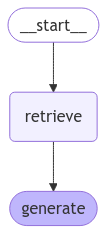

In [383]:
graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

In [384]:
def deduplicate_consecutive_citations(text):
    # Find groups of consecutive citations and deduplicate them
    def replace_consecutive(match):
        citations = re.findall(r'\[(\d+)\]', match.group(0))
        unique_citations = []
        for citation in citations:
            # Only remove duplicates within this consecutive group
            if citation not in unique_citations:
                unique_citations.append(citation)
        return ''.join(f'[{citation}]' for citation in unique_citations)
    
    # Pattern to match one or more consecutive citations
    pattern = r'(?:\[\d+\])+' 
    return re.sub(pattern, replace_consecutive, text)

def format_final_answer(result):
    # extract the citation ids from the answer
    citation_pattern = re.compile(r"\^\[(\d+)\]")
    citation_ids = citation_pattern.findall(result['answer'])
    citation_ids = set([int(id) for id in citation_ids])

    # find the source for each citation
    citation_data = []
    source_metadata = result['formatted_sources']['source_dicts']

    for submodule_source in source_metadata:
        matching_ids = set(submodule_source['source_ids']).intersection(citation_ids)
        if matching_ids:
            citation = {"submodule_url": submodule_source['submodule_url'], 
                        "submodule_title": submodule_source['submodule_title'],
                        "old_citation_ids": [], "block_ids": []}
            for source_split in submodule_source['source_splits']:
                if source_split['source_id'] in matching_ids:
                    citation['old_citation_ids'].append(source_split['source_id'])
                    citation['block_ids'].append(source_split['block_id'])
            citation_data.append(citation)

    # Sort by the minimum value in 'citation_ids'
    citation_data = sorted(citation_data, key=lambda x: min(x['old_citation_ids']))

    # process the final citation url and id
    new_citation_id = 1
    for citation in citation_data:
        citation['final_url'] = citation['submodule_url'] + "/block/" + ",".join(citation['block_ids'])
        citation['new_citation_id'] = new_citation_id
        new_citation_id += 1

    # reformat the answer with the new citation ids
    final_answer = result['answer']
    for citation in citation_data:
        for old_citation_id in citation['old_citation_ids']:
            final_answer = final_answer.replace(f"^[{old_citation_id}]", f"[{citation['new_citation_id']}]")
    
    final_citation = {}
    for citation in citation_data:
        final_citation[citation['new_citation_id']] = {"url": citation['final_url'], "title": citation['submodule_title']}
        
    # deduplicate the final citation
    final_answer = deduplicate_consecutive_citations(final_answer)
    
    return {"content": final_answer, "citation": final_citation}

In [385]:
result = graph.invoke({"question": "What are different ways to calculate GDP? Please explain them as well."})

In [386]:
final_answer = format_final_answer(result)
print(final_answer['content'])
print("\nCitations:\n")
print(final_answer['citation'])

Gross Domestic Product (GDP) can be calculated using different approaches, including the production-based, expenditure-based, and income-based methods[1].

1. **Production-based method**: This method calculates GDP by measuring the gross value added from production. It involves taking the total value of goods and services produced and subtracting the cost of inputs used in production to avoid double-counting[1].

2. **Expenditure-based method**: This approach calculates GDP by looking at what is spent on the acquisition of final products and services within a specific time period. It essentially sums up all expenditures or spending in the economy[1].

3. **Income-based method**: This method calculates GDP by adding up all the income earned by households in a year, including wages, rent, and interest. It focuses on the income generated from the production of goods and services[1]. 

In a closed economy, where there is no trade with other countries, these three methods should yield the s

In [318]:
result = graph.invoke({"question": "What is the difference between economic and social impact?"})

In [347]:
final_answer = format_final_answer(result)
print(final_answer['content'])
print("\nCitations:\n")
print(final_answer['citation'])

Economic and social impacts differ primarily in their focus and the aspects they assess. Economic impact assessment (EIA) evaluates changes in employment, income, and economic opportunities, often considering both direct and indirect economic impacts such as capital investment, expenditure, revenue, job creation, and broader economic activities like supplier activity and GDP contributions[1][3]. On the other hand, Social Impact Assessment (SIA) focuses on understanding and managing the social consequences of projects, aiming to enhance positive impacts while mitigating negatives. It involves community engagement, stakeholder analysis, and ongoing monitoring to address issues like human rights, labour practices, and community involvement[1][2].

Citations:

{1: 'https://rise.articulate.com/share/8iOLwHdO2sKg9AXhYYPKLmwK2Y4nEvlT#/lessons/iKoNSrZZUh8A64HAzMc6bJZSUJk64BaO/block/cm3yy4wpb00500hh52jed6o0i', 2: 'https://rise.articulate.com/share/8iOLwHdO2sKg9AXhYYPKLmwK2Y4nEvlT#/lessons/4wWOi

In [349]:
result = graph.invoke({"question": "Is wildlife population related to sustainability?"})

In [350]:
final_answer = format_final_answer(result)
print(final_answer['content'])
print("\nCitations:\n")
print(final_answer['citation'])

Yes, wildlife population is related to sustainability. The concept of sustainability encompasses three pillars: environmental, social, and economic factors[1]. Wildlife populations are a crucial component of the environmental pillar, as they contribute to biodiversity and ecosystem health. Maintaining healthy wildlife populations is essential for ecological balance, which in turn supports sustainable development by ensuring that natural resources are available for future generations[1].

Citations:

{1: 'https://rise.articulate.com/share/x4kLM8ubXkKXbaSIIYxdg2lUAat8jkZA#/lessons/xQ0MAAQZcoTdT-aLBQ8CCT8kZcGhcVFW/block/cm1twcgkr00a63j7581kkjwzb,cm1twck6k00ar3j75ide8wpkh'}


In [374]:
result = graph.invoke({"question": "How to make the fastest car in the world?"})

In [375]:
final_answer = format_final_answer(result)
print(final_answer['content'])
print("\nCitations:\n")
print(final_answer['citation'])

Sorry, I can't find any relevant course content related to your question.

Citations:

{}
